In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
# Draw Functions
def draw_contours(image, contours):
    image_copy = image.copy()
    for c in contours:
        cv2.drawContours(image_copy, [c], -1, (0, 255, 0), 2)
    cv2_imshow(image_copy)

def draw_lines_on_image(image, lines):
    image_with_lines = image.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2_imshow(image_with_lines)

In [3]:
# Edge Detection
def apply_edge_detection(image):
    T_LOWER = 30
    T_UPPER = 100
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edge = cv2.Canny(blurred, T_LOWER, T_UPPER)
    return edge

In [4]:
# Heuristic Check (is there a board?)
def has_grid_pattern(edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=40, maxLineGap=10)

    # Check that a good number of vertical + horizontal lines are present
    if lines is None or len(lines) < 10:
        return False

    vertical = 0
    horizontal = 0
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = abs(np.arctan2((y2 - y1), (x2 - x1)) * 180.0 / np.pi)
        if angle < 10:  # near-horizontal
            horizontal += 1
        elif angle > 80:  # near-vertical
            vertical += 1

    return vertical >= 6 and horizontal >= 6

In [5]:
def find_squares(contours):
    candidates = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 500:
            continue

        rect = cv2.minAreaRect(contour)
        (cx, cy), (w, h), angle = rect

        if w == 0 or h == 0:
            continue

        # Test square aspect ratio with 10% error
        aspect_ratio = max(w, h) / min(w, h)
        if 0.9 < aspect_ratio < 1.1:
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            candidates.append((box, area))

    return candidates

def return_largest_contour(contour_candidates):
    largest_area = 0
    largest_box = None
    for box, area in contour_candidates:
        if area > largest_area:
            largest_area = area
            largest_box = box
    return largest_box

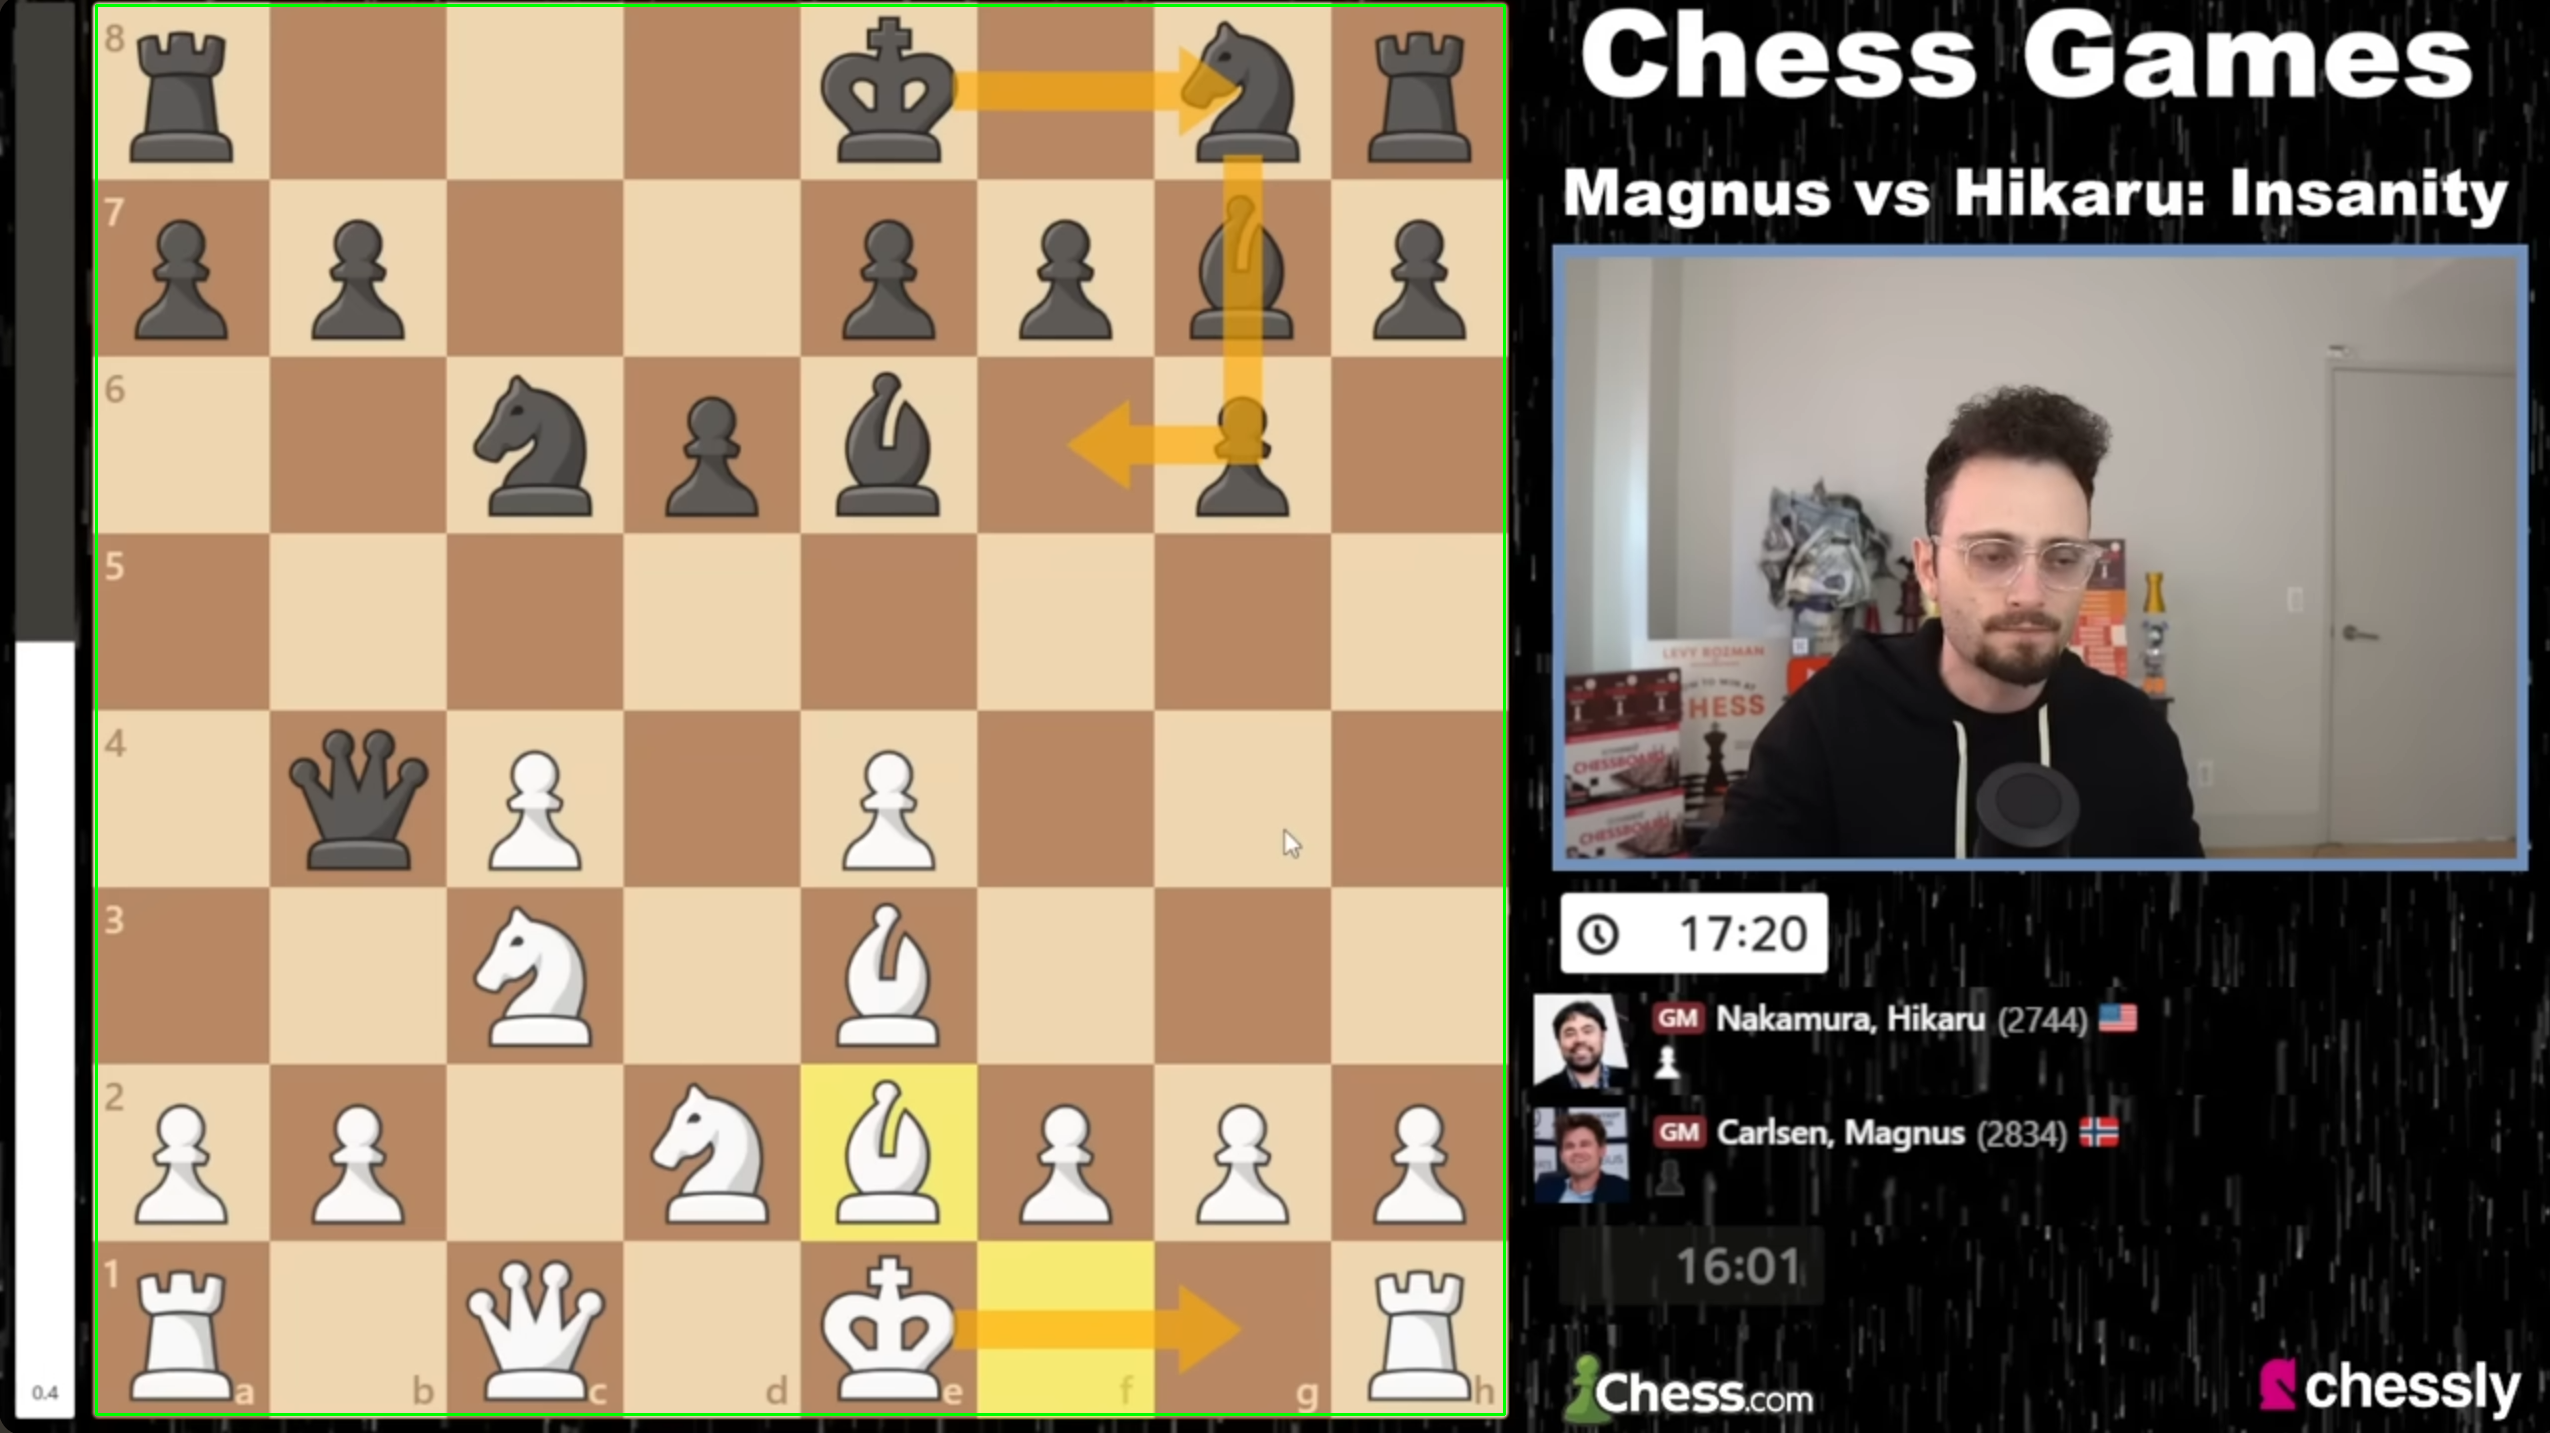

In [6]:
def main():
    img = cv2.imread("test_image.png")
    edges = apply_edge_detection(img)

    if not has_grid_pattern(edges):
        print("No grid pattern found.")

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = find_squares(contours)
    largest = return_largest_contour(candidates)

    draw_contours(img, [largest])

main()